In [1]:
import tensorflow_core as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import seaborn as sb
import scipy as sp
import sklearn.preprocessing as skp
import sklearn.model_selection as skm

import sys
np.set_printoptions(threshold=sys.maxsize)

In [2]:
def convert_to_one_hot(y_dataset, num_labels):
    y_one_hot = np.array([-99.] * num_labels)
    for val in y_dataset:
        one_hot = np.array(\
            [0.] * (val - 1) + [1.] + [0.] * (10 - val))
        y_one_hot = np.vstack((y_one_hot, one_hot))
    
    return y_one_hot[1:] # remove first dummy

red_wines = pd.read_csv("./winequality-red.csv")

x_dataset = red_wines.drop(\
    ["quality"], axis=1).to_numpy()
y_dataset =  red_wines["quality"].to_numpy()

x_train, x_test, y_train, y_test = \
    skm.train_test_split(\
         x_dataset, \
         y_dataset, \
         random_state = 0, test_size = 0.15)

y_train_one_hot = convert_to_one_hot(y_train, 10)
y_test_one_hot = convert_to_one_hot(y_test, 10)

scaler = skp.StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [3]:
def plot_pie_chart(x_dataset, y_dataset):
    clusters = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    clusters_label = np.array(\
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

    for i in range(x_dataset.shape[0]):
        clusters[int(y_dataset[i]) - 1] += 1

    colors = sb.color_palette("Paired", 10)
    
    labels = ['{0:02d} - {2:04d} units ({1:1.2f} %)'.format(i,j, k) \
        for i,j, k in zip(clusters_label, \
           100.*clusters/clusters.sum(),
           clusters)]

    patches, texts = plt.pie(clusters, colors=colors, radius=1.25)

    sorted_zip = np.column_stack(\
         (patches, labels, clusters, clusters_label))

    sorted_zip = sorted_zip[np.apply_along_axis(lambda x: x[2], 1, sorted_zip).argsort()[::-1]]

    plt.legend(sorted_zip[:, 0], sorted_zip[:, 1], bbox_to_anchor=(1.9,1.0), \
        loc="upper right", fontsize=10)

    plt.show()
    

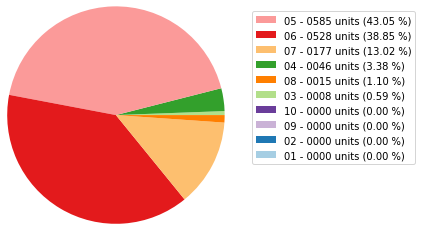

In [4]:
plot_pie_chart(x_train, y_train)

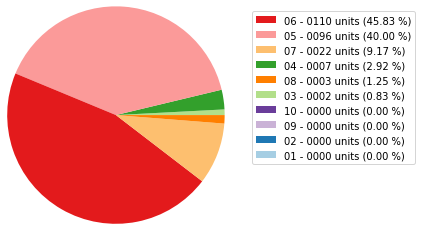

In [5]:
plot_pie_chart(x_test, y_test)

In [6]:
num_features = x_train.shape[1]
num_labels = 10 # 10 quality

X = tf.placeholder(tf.float32, shape=[None, num_features], name="x")
Y = tf.placeholder(tf.float32, shape=[None, num_labels], name="y")

# same idea as (x_1 * w_1) + w_0 
w = tf.Variable(tf.zeros([num_features, num_labels]), name="w", trainable=True)
b = tf.Variable(tf.zeros([num_labels]), name="b", trainable=True)

reg_lambda = tf.placeholder(tf.float32, name="reg")

def model(X, w, b):
    logits = tf.add(tf.matmul(X, w), b)
    
    sum_dimension = 1 # quality for each feature
    
    sum_logits = tf.reduce_sum(\
        tf.reduce_sum(\
            tf.exp(logits), sum_dimension))
    
    return tf.divide(tf.exp(logits), sum_logits)

y_model = model(X, w, b)

In [7]:
learning_rate = 0.001
training_epochs = 1000

cost = tf.add(
    -tf.reduce_sum(Y * tf.log(y_model)),
    tf.multiply(reg_lambda, tf.add(
        tf.reduce_sum(tf.square(w)),
        tf.reduce_sum(tf.square(b)))))
# cost = -tf.reduce_sum(Y * tf.log(y_model))
train_op = tf.train.GradientDescentOptimizer(learning_rate)\
    .minimize(cost)

In [8]:
min_cost = x_train.size
final_w = np.zeros((num_features, num_labels))
final_b = np.zeros((num_labels))

print(x_train.shape)
print(y_train_one_hot.shape)
print(y_test.shape)
print(y_test_one_hot.shape)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

train_size = x_train.shape[0]
batch_size = 100

for lambda_val in np.linspace(0, 1, 100):

    total_batch = training_epochs * train_size // batch_size
    for step in range(total_batch):
        offset = (step * batch_size) % train_size
        batch_xs = x_train[offset:(offset + batch_size)]
        batch_labels = y_train_one_hot[offset:(offset + batch_size)]
        sess.run(train_op, feed_dict={X: batch_xs, Y: batch_labels,\
                                 reg_lambda: lambda_val})
    
    testing_cost = sess.run(cost, \
        feed_dict={X: x_test, Y: y_test_one_hot,\
                  reg_lambda: lambda_val})
    
    print(final_w)
    print(final_b)
    
    if testing_cost <= min_cost:
        min_cost = testing_cost
        final_w = sess.run(w)
        final_b = sess.run(b)
        


    # reset parameters
    w.assign(tf.zeros([num_features, num_labels]))
    b.assign(tf.zeros([num_labels]))

sess.close()                    

(1359, 11)
(1359, 10)
(240,)
(240, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02 

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

[[-3.0650673e-03 -3.0650673e-03  1.9376732e-01  2.0360060e-01
  -2.6054794e-01 -1.1371118e-01  2.7819565e-01 -5.4965770e-01
  -3.0650673e-03 -3.0650673e-03]
 [ 1.4516368e-03  1.4516368e-03  8.0152798e-01  5.5166775e-01
   1.0734044e-01 -1.7850503e-01 -4.8123261e-01  3.9343715e-01
   1.4516368e-03  1.4516368e-03]
 [-3.1643892e-03 -3.1643892e-03 -6.8224329e-01  2.8573889e-01
   1.4642453e-02 -1.7039390e-01  1.6907761e-01  7.2506785e-01
  -3.1643892e-03 -3.1643892e-03]
 [-3.7239701e-03 -3.7239701e-03  8.2092784e-02  1.8572259e-01
  -1.0071478e-01 -7.2822355e-02  2.0907032e-01 -3.8004684e-01
  -3.7239701e-03 -3.7239701e-03]
 [ 6.2732711e-03  6.2732711e-03  6.8332225e-01  1.6936168e-01
   7.4821919e-02 -2.7415728e-02 -2.8326839e-01 -8.3670932e-01
   6.2732711e-03  6.2732711e-03]
 [-2.6010694e-03 -2.6010694e-03  3.9944580e-01  8.2812890e-02
  -5.5770345e-02  1.2811162e-01  7.9035275e-02  3.0837438e-01
  -2.6010694e-03 -2.6010694e-03]
 [ 9.2025689e-04  9.2025689e-04 -1.1835228e+00 -5.5802685e

In [ ]:
from sklearn.metrics import confusion_matrix

def make_prediction(x, w, b):
    logits = np.add(np.matmul(x, w), b)
    
    sum_dimension = 1 # quality for each feature
    
    sum_logits = np.sum(\
        np.sum(\
            np.exp(logits), axis=sum_dimension))
    
    return np.argmax(\
        np.divide(np.exp(logits), sum_logits),\
            sum_dimension) + 1

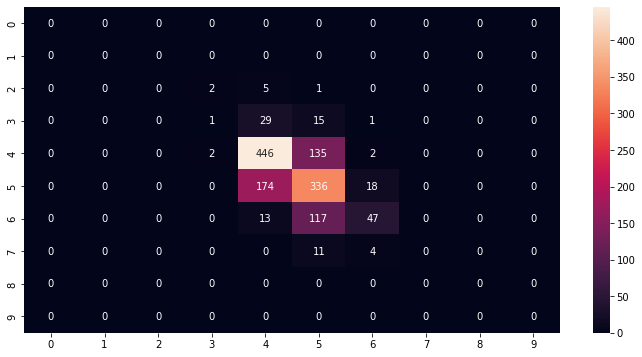

In [24]:
cm = confusion_matrix(y_train, \
    make_prediction(x_train, final_w, final_b), \
    labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.figure(figsize = (12,6))
sb.heatmap(cm, annot=True, fmt='g')
plt.show()

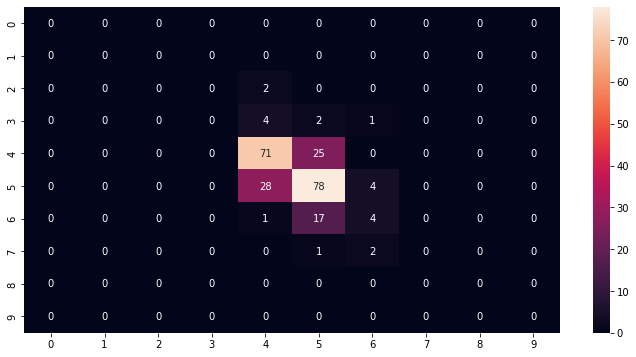

In [25]:
cm = confusion_matrix(y_test, \
    make_prediction(x_test, final_w, final_b), \
    labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.figure(figsize = (12,6))
sb.heatmap(cm, annot=True, fmt='g')
plt.show()